In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("dataset_phishing.csv")

# Clean column names
df.columns = df.columns.str.strip()

df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [5]:
X = df.drop(["url", "status"], axis=1)
y = df["status"]

In [6]:
print(y.value_counts())

legitimate    5715
phishing      5715
Name: status, dtype: int64


In [9]:
y = y.replace(-1, 0)

In [12]:
# Convert text labels to numeric
y = y.replace({
    "legitimate": 0,
    "phishing": 1
})

print(y.unique())


[0 1]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)



In [17]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values



In [18]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred = xgb_model.predict(X_test)


In [20]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


XGBoost Accuracy: 0.9728783902012248

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1157
           1       0.98      0.97      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



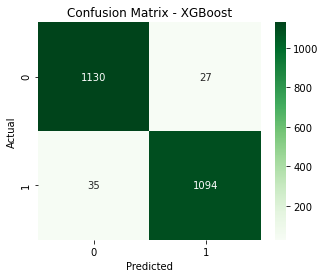

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [22]:
feature_importance = pd.DataFrame({
    "Feature": df.drop(["url", "status"], axis=1).columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance.head(15)

,Feature,Importance
85,google_index,0.538611
86,page_rank,0.029920
20,nb_www,0.026987
56,nb_hyperlinks,0.026549
6,nb_qm,0.025293
26,ratio_digits_host,0.017969
50,phish_hints,0.017170
9,nb_eq,0.013836
23,http_in_path,0.013423
2,ip,0.012609


In [23]:
import joblib
joblib.dump(xgb_model, "xgboost_phishing_model.pkl")

['xgboost_phishing_model.pkl']

In [24]:
feature_columns = df.drop(["url", "status"], axis=1).columns

joblib.dump(feature_columns, "feature_columns.pkl")

print("Feature columns saved!")

Feature columns saved!
